# Install cohere

Must have `CO_API_KEY` in your environment

In [4]:
#!pip install cohere

# Use cohere multi-modal embeddings


In [21]:
import os
import cohere
import requests
import base64
from PIL import Image
from io import BytesIO

def get_embedding(input_text):
    """
    Get embeddings using Cohere API for either text or image URLs
    Args:
        input_text (str): Text string or image URL to embed
    Returns:
        list: Embedding vector
    """
    co = cohere.Client(os.getenv('CO_API_KEY'))
    
    # Check if input is URL by attempting to make a request
    try:
        response = requests.head(input_text)
        if response.status_code == 200 and response.headers.get('content-type', '').startswith('image'):
            # It's an image URL
            image_response = requests.get(input_text)
            # Convert image to base64
            stringified_buffer = base64.b64encode(image_response.content).decode("utf-8")
            content_type = image_response.headers["Content-Type"]
            image_base64 = f"data:{content_type};base64,{stringified_buffer}"
            
            # Get image embedding
            response = co.embed(
                model="embed-english-v3.0", 
                input_type='image',
                embedding_types=["float"],
                images=[image_base64],
            )
        else:
            raise requests.exceptions.RequestException
            
    except requests.exceptions.RequestException:
        # It's text
        # Ensure text is properly encoded as UTF-8
        if isinstance(input_text, bytes):
            input_text = input_text.decode('utf-8', errors='ignore')
        
        response = co.embed(
            texts=[input_text],
            model='embed-english-v3.0',
            input_type='classification',
            embedding_types=["float"],
        )
    
    return response.embeddings.float[0]

#get_embedding("text123")
get_embedding("https://images.unsplash.com/photo-1733077151631-93a7e457b97f?w=800&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxmZWF0dXJlZC1paG90b3MtZmVlZHw1fHx8ZW58MHx8fHx8")


[-0.013130188,
 0.014282227,
 -0.045898438,
 -0.0055770874,
 -0.010101318,
 -0.03479004,
 0.004951477,
 -0.0026779175,
 -0.023208618,
 0.09136963,
 -0.023376465,
 0.038970947,
 0.026000977,
 -0.0021591187,
 -0.012504578,
 -0.012268066,
 0.0107421875,
 0.021514893,
 0.032073975,
 -0.0026245117,
 0.031204224,
 0.004272461,
 0.0027885437,
 -0.053833008,
 0.04067993,
 0.024597168,
 -0.042633057,
 -0.0022640228,
 -0.0138549805,
 -0.0053138733,
 -0.010826111,
 0.009338379,
 0.011795044,
 0.034088135,
 -0.030273438,
 -0.00945282,
 -0.04663086,
 0.01499176,
 0.014419556,
 0.010444641,
 0.016662598,
 0.010620117,
 -0.014419556,
 0.046325684,
 -0.0670166,
 -0.013114929,
 -0.03074646,
 -0.033721924,
 0.017227173,
 0.05758667,
 -0.007282257,
 -0.01637268,
 -0.007209778,
 0.01802063,
 -0.014251709,
 -0.014198303,
 0.0127334595,
 -0.043792725,
 0.042633057,
 -0.033203125,
 -0.042114258,
 0.0068969727,
 0.05444336,
 0.01701355,
 0.017196655,
 -0.029571533,
 -0.016799927,
 -0.007873535,
 0.00995636,
 

# Embedd existing dbd with cohere

In [6]:
import pandas as pd
# read json objects, line by line, in json/data-barn-delights.jsonl into a dataframe
df = pd.read_json('json/data-barn-delights.jsonl', lines=True)

In [7]:
# create a new column, named embedding in the dataframe calling get_embedding for text column
df['embedding'] = df['text'].apply(get_embedding)


# Embed text or images and compare to dbd

In [19]:
# Define two product IDs and custom text
product1_id = 'apple'
product2_id = 'sports-drink' 
#custom_text = "fruit"
custom_text = "https://images.unsplash.com/photo-1453487021979-5b739b2849f4?q=80&w=2013&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"


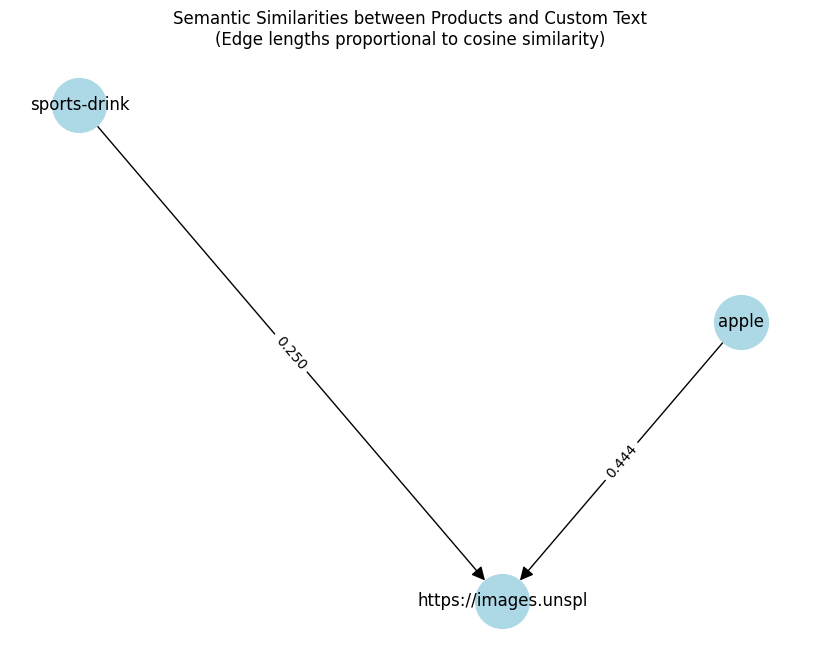

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



# Get embeddings for the two products from dataframe
product1_data = df[df['id'] == product1_id]
product2_data = df[df['id'] == product2_id]

# Get embedding for custom text
custom_embedding = get_embedding(custom_text)

if len(product1_data) == 0 or len(product2_data) == 0:
    print(f"Error: Could not find {product1_id} or {product2_id} in the dataset")
else:
    product1_embedding = product1_data['embedding'].values[0]
    product2_embedding = product2_data['embedding'].values[0]

    # Calculate cosine similarities
    p1_custom_sim = cosine_similarity([product1_embedding], [custom_embedding])[0][0]
    p2_custom_sim = cosine_similarity([product2_embedding], [custom_embedding])[0][0]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges with distances
    G.add_edge(product1_id, custom_text[:20], weight=p1_custom_sim)
    G.add_edge(product2_id, custom_text[:20], weight=p2_custom_sim)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    
    # Create a layout where edge lengths are directly proportional to similarities
    pos = {}
    pos[custom_text[:20]] = np.array([0, 0])  # Place custom text at origin
    
    # Calculate positions based on similarities
    # Higher similarity = shorter distance
    angle_p1 = np.pi/3  # 60 degrees
    angle_p2 = 2*np.pi/3  # 120 degrees
    
    # Scale factor for visualization (inverse of similarity for distance)
    scale = 3.0
    
    pos[product1_id] = np.array([
        scale * (1/p1_custom_sim) * np.cos(angle_p1),
        scale * (1/p1_custom_sim) * np.sin(angle_p1)
    ])
    pos[product2_id] = np.array([
        scale * (1/p2_custom_sim) * np.cos(angle_p2),
        scale * (1/p2_custom_sim) * np.sin(angle_p2)
    ])

    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1500, arrowsize=20, font_size=12)

    # Add edge labels (similarities)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title('Semantic Similarities between Products and Custom Text\n(Edge lengths proportional to cosine similarity)')
    plt.show()

In [22]:
# Define a query text
query_text = "https://images.unsplash.com/photo-1453487021979-5b739b2849f4?q=80&w=2013&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# Get query embedding using the same model used for products
query_embedding = get_embedding(query_text)

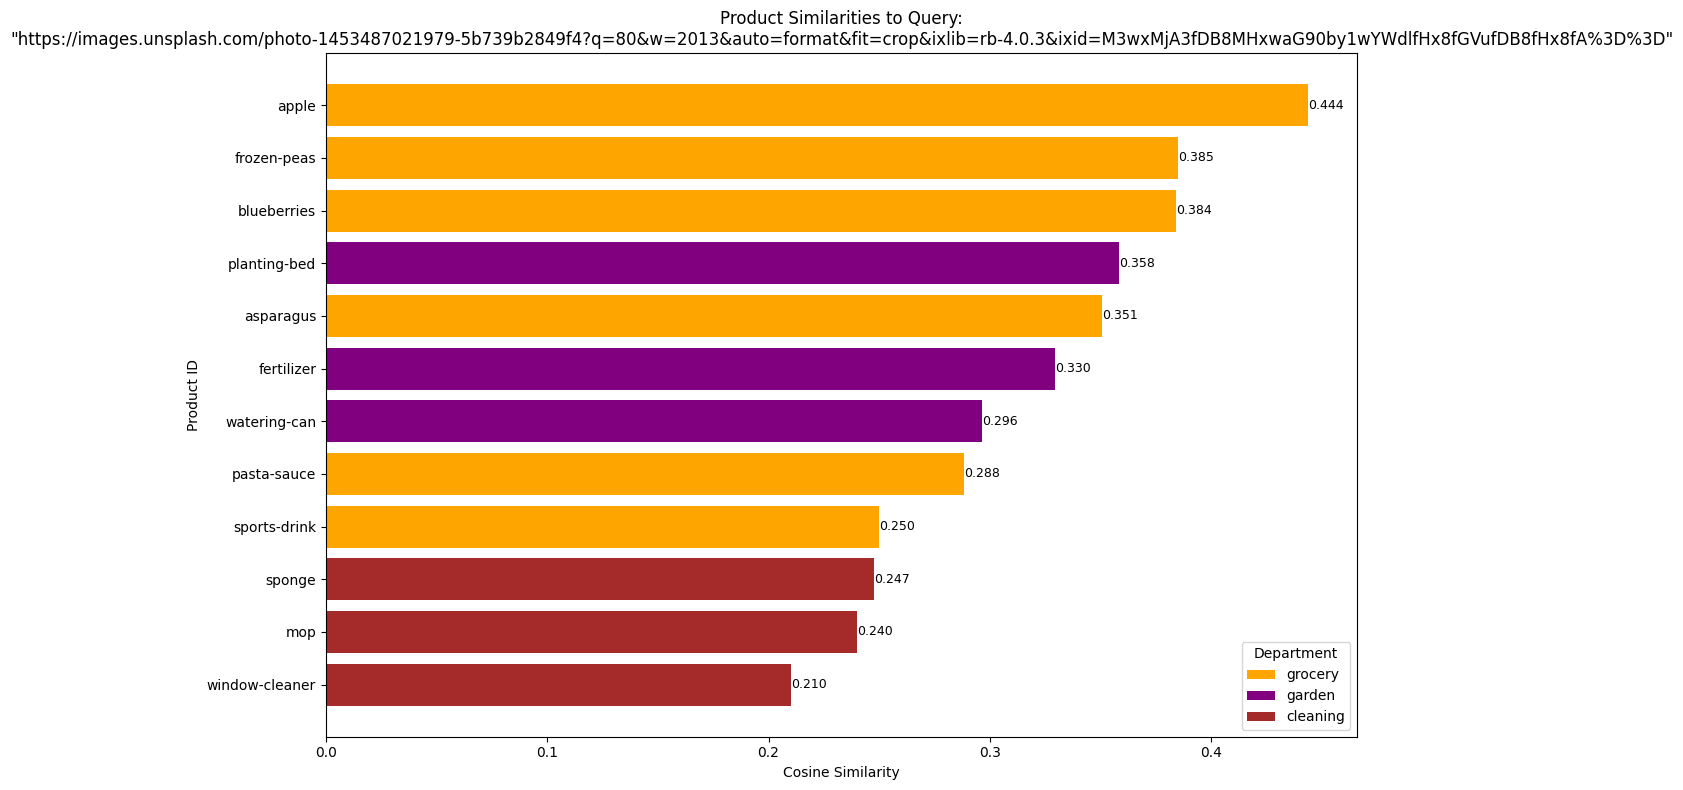

In [23]:


# Calculate cosine similarities with all products
similarities = []
for emb in df['embedding']:
    sim = cosine_similarity([query_embedding], [emb])[0][0]
    similarities.append(sim)

# Add similarities to dataframe
df['similarity_score'] = similarities

# Sort by similarity
df_sorted = df.sort_values('similarity_score', ascending=True)

# Create color mapping for departments
department_colors = {
    'grocery': 'orange',
    'garden': 'purple',
    'cleaning': 'brown'
}

# Create horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(df_sorted['id'], df_sorted['similarity_score'], 
                color=[department_colors[d] for d in df_sorted['meta_department']])

# Customize the plot
plt.xlabel('Cosine Similarity')
plt.ylabel('Product ID')
plt.title(f'Product Similarities to Query:\n"{query_text}"')

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=dept) 
                  for dept, color in department_colors.items()]
plt.legend(handles=legend_elements, title='Department', loc='lower right')

# Add value labels on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()
